<div dir=rtl>

# עיבוד שפה טבעית (20225211) 2023-2024 - תרגיל 2 שאלה 3

שלום לכולםן!

התרגיל שלהלן יתבסס במידה רבה על ההדרכה שעברתןם ב-24/1 ויעקוב באופן כללי אחרי אותם שלבים - ניתן ומומלץ להיעזר ב[מחברת ההדרכה](https://colab.research.google.com/drive/1CVllovh2b6AXCNr6amTNamB9lEttY385?usp=drive_link). המטרה היא לבנות רשת נשנית שמתייגת חלקי דיבר עבור סלאבית כנסייתית עתיקה.

בסיום העבודה, הגישו **קובץ pdf** הכולל את כל הפלטים מכל התאים. דרך אפשרית אחת להשיג קובץ pdf היא על-ידי הדפסת הדף (מתוך colab, לא מהדפדפן) ולבחור "מדפסת" ישירה ל-pdf. אני מזכיר שמועד ההגשה עבור כל חלקי התרגיל הינו **6/2/24, 13:59**.

בהצלחה,

-- יובל

</div>

<div dir=rtl>

# התקנות

כמו במקרה הקודם, נוכל להשתמש בחבילות עיבוד השפה של [האגינגפייס](https://huggingface.co/) על-מנת לטעון את הדאטא.
כיוון שאנחנו טוענים דאטא בפורמט מטוקנז של UD, נצטרך להתקין גם חבילה התומכת בו.

</div>

In [4]:
!pip install datasets -q
!pip install tokenizers -q
!pip install conllu -q

<div dir=rtl>

# ייבוא

נצטרך כמעט את כל החבילות שהתקנו עבור הרשת הנשנית למסמכים.

</div>

In [27]:
import matplotlib.pyplot as plt  # for plotting
import pandas as pd  # only to show some data in a nice table
import torch
import numpy as np

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer

from datasets import load_dataset
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # progress bar

<div dir=rtl>

# זרע הפורענות

משהו שכדאי לעשות בזמן שמפתחים מודל הוא להמעיט באקראיות ככל הניתן.
בחבילות הנומריות של פייתון כמו numpy ו-pytorch יש הרבה מאוד אלמנטים אקראיים, כמו איך פרמטרים מאותחלים, או באיזה סדר נופל דאטאסט אם אנחנו בוחרים לערבב אותו בכל איטרציה (מומלץ באופן כללי, לא נממש הפעם).
הדרך שלנו לשלוט באלמנטים האלה כדי שיהיו זהים בכל הרצה (ובין היתר, להקל על בדיקת התרגיל) היא לקבוע זרע אקראי בתחילת ההרצה, שממנו תנבע האקראיות באופן דטרמיניסטי. הבה:

</div>

In [6]:
SEED = 5784

import random
from numpy import random as nprnd

random.seed(SEED)
nprnd.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

<div dir=rtl>

# מה בדאטא?

כמו בניתוח סנטימנט, אנחנו רוצים לדעת עם מה יש לנו עסק. לטעון מתוך UD זה קל עם חבילת datasets, ובשביל לגשת לשדות השונים, ניתן להיעזר ב[דף התיעוד](https://huggingface.co/datasets/universal_dependencies).
אותנו מעניין רק הטקסט וחלקי הדיבר UPOS (בשלב הזה) ולכן נסתכל על כמה דוגמאות:

</div>

In [7]:
pd.set_option('display.max_colwidth', None)
dataset = load_dataset(
   'universal_dependencies', 'cu_proiel')
dataset.set_format(type="pandas", columns=["text", "tokens", "upos"])
dataset['validation'][:10]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,tokens,upos
0,остави тоу даръ твои прѣдъ олътаремъ ꙇ шедъ прѣжде съмири сѧ съ братромъ своимъ и тогда пришедъ принеси даръ твои,"[остави, тоу, даръ, твои, прѣдъ, олътаремъ, ꙇ, шедъ, прѣжде, съмири, сѧ, съ, братромъ, своимъ, и, тогда, пришедъ, принеси, даръ, твои]","[16, 14, 0, 6, 2, 0, 9, 16, 14, 16, 11, 2, 0, 6, 9, 14, 16, 16, 0, 6]"
1,Бѫди оувѣщаѩ сѧ съ сѫпьремь своимь скоро доньдеже еси на пѫти съ нимь да не прѣдастъ тебе сѫдии ꙇ сѫдии тѧ прѣдастъ слоуѕѣ ꙇ въ темьницѫ въвръжетъ тѧ,"[Бѫди, оувѣщаѩ, сѧ, съ, сѫпьремь, своимь, скоро, доньдеже, еси, на, пѫти, съ, нимь, да, не, прѣдастъ, тебе, сѫдии, ꙇ, сѫдии, тѧ, прѣдастъ, слоуѕѣ, ꙇ, въ, темьницѫ, въвръжетъ, тѧ]","[17, 16, 11, 2, 0, 6, 14, 5, 17, 2, 0, 2, 11, 5, 14, 16, 11, 0, 9, 0, 11, 16, 0, 9, 2, 0, 16, 11]"
2,аминь г҃лѭ тебѣ,"[аминь, г҃лѭ, тебѣ]","[15, 16, 11]"
3,не изидеши отъ тѫдѣ доньдеже въздаси послѣдьнии кодрантъ,"[не, изидеши, отъ, тѫдѣ, доньдеже, въздаси, послѣдьнии, кодрантъ]","[14, 16, 14, 14, 5, 16, 6, 0]"
4,Слꙑшасте ѣко речено бꙑⷭ҇ древънимъ,"[Слꙑшасте, ѣко, речено, бꙑⷭ҇, древънимъ]","[16, 5, 16, 17, 6]"
5,не прѣлюбꙑ сътвориши,"[не, прѣлюбꙑ, сътвориши]","[14, 0, 16]"
6,азъ же г҃лѭ вамъ ѣко вьсѣкъ иже вьзьритъ на женѫ съ похотиѭ юже любꙑ сътвори съ неѭ въ с҃рдци своемь,"[азъ, же, г҃лѭ, вамъ, ѣко, вьсѣкъ, иже, вьзьритъ, на, женѫ, съ, похотиѭ, юже, любꙑ, сътвори, съ, неѭ, въ, с҃рдци, своемь]","[11, 14, 16, 11, 5, 6, 11, 16, 2, 0, 2, 0, 14, 0, 16, 2, 11, 2, 0, 6]"
7,аще же око твое десное съблажнаатъ тѧ ꙇзьми е и връзи отъ тебе,"[аще, же, око, твое, десное, съблажнаатъ, тѧ, ꙇзьми, е, и, връзи, отъ, тебе]","[5, 14, 0, 6, 6, 16, 11, 16, 11, 9, 16, 2, 11]"
8,оунѣе бо ти естъ да погꙑблетъ единъ оудъ твоихъ а не вьсе тѣло твое въвръжено бѫдетъ въ ꙉеонѫ,"[оунѣе, бо, ти, естъ, да, погꙑблетъ, единъ, оудъ, твоихъ, а, не, вьсе, тѣло, твое, въвръжено, бѫдетъ, въ, ꙉеонѫ]","[6, 14, 11, 17, 5, 16, 3, 0, 6, 9, 14, 8, 0, 6, 16, 17, 2, 0]"
9,ꙇ аште десна твоѣ рѫка съблажнаатъ тѧ оусѣци ѭ и връзи отъ себе,"[ꙇ, аште, десна, твоѣ, рѫка, съблажнаатъ, тѧ, оусѣци, ѭ, и, връзи, отъ, себе]","[9, 5, 6, 6, 0, 16, 11, 16, 11, 9, 16, 2, 11]"


<div dir=rtl>

המממ. קצת פחות ברור מה שקורה פה מאשר בדוגמת המסמכים השלמים. קודם כל, אנחנו לא דוברים סלאבית כנסייתית עתיקה. [הנה](https://en.wikipedia.org/wiki/Old_Church_Slavonic) ערך הויקיפדיה שלה ו[הנה](https://www.languagesgulper.com/eng/Slavonic.html) הסבר נוסף, והם יספרו לנו על תכונות של השפה שאולי יעזרו לנו להבין בהמשך אם יש תופעות שכדאי להתייחס אליהן מפורשות.

הדבר השני שאנחנו מתקשים איתו הוא פורמט התגים, שמופיעים כאן אחרי שכבר מופו לאינדקסים ע"י מי שהזין אותם לשרתי האגינגפייס. למזלנו, דאגו לנו גם לשמירת המיפוי בתוך הדאטאסט, וניתן לגשת אליו מתוך כל אחד מחיתוכי הדאטא (splits).

</div>

In [8]:
val_tags = dataset['validation'].features['upos'].feature.names
[f'{i:2}: {p}' for (i,p) in enumerate(val_tags)]

[' 0: NOUN',
 ' 1: PUNCT',
 ' 2: ADP',
 ' 3: NUM',
 ' 4: SYM',
 ' 5: SCONJ',
 ' 6: ADJ',
 ' 7: PART',
 ' 8: DET',
 ' 9: CCONJ',
 '10: PROPN',
 '11: PRON',
 '12: X',
 '13: _',
 '14: ADV',
 '15: INTJ',
 '16: VERB',
 '17: AUX']

<div dir=rtl>

סקירת-שפיות קצרה של הדאטא מהתא הקודם תראה לנו שבאמת ברוב המשפטים יש פועל (16), כפי שאנו מצפים מכל שפה, ושיש כמות סבירה של שמות עצם (0). נשים לב שאו שזה מקור שנכתב (בעת העתיקה) ללא סימני פיסוק (1), או שהם הוסרו בעת עריכת המשאב.

1. מצאו משפט מהקישור השני על השפה (לעיל) שמסביר מדוע הפעלים נמצאים במקומות מגוונים על-פני המשפטים שדגמנו.

---

**"Old Church Slavonic had apparently a free word order, all possible orders of subject, object and verb are found"**

---


</div>

<div dir=rtl>

כיוון שאנחנו חשדנים.ות מטבענו, ולא נרצה שנאמן את המודל על רשימת תגים מסוימת ואח"כ נבחן אותו על אינדקסים לא-תואמים (מה שיכול לגרום לכך שכל החיזויים שלנו לשמות עצם יפורשו כחיזויים לפעלים), נכתוב קוד קצר שמוודא שסדר התגים זהה עבור אימון, ולידציה ומבחן.

2. כתבו קוד שמוודא את סדר התגים לשלושת חלקי הדאטאסט. ניתן להשתמש בפונקציית `assert`.
**מגישים ביחיד.ה פטורים.ות מהסעיף**

</div>

In [9]:
array = []
for group in ['train', 'validation', 'test']:
  tags = dataset[group].features['upos'].feature.names
  array.append(tags)
assert array[0] == array[1] == array[2]

<div dir=rtl>

# טוקנייזר

בעית הטיקנוז שלנו קלה אפילו יותר מזו שהיתה בניתוח סנטימנט. המסמכים שלנו באים עם חלוקה לטוקנים מראש, ולכן אפשר פשוט להעביר לטוקנייזר שנבנה בתור ברירת מחדל את הפרמטר לפיו המידע שהוא מקבל כבר עבר "טרום-טוקניזציה".
על-כן:
1. נטען את הדאטאסט
1. ניצור טוקנייזר פשוט
1. נגדיר לו את התבנית למילים לא ידועות `UNK` ואת תבנית הריפוד `PAD`
1. נאמן את הטוקנייזר
1. נספר לו איך לרפד.

אחר-כך נצטרך לטפל גם בטוקנייזר עבור התגים, בעיקר כדי לשמור על מדיניות ריפוד אחידה (המודולים ב-`torch` יצפו לאורך רצפים אחידים בין הקלט לתגים).
בשני המקרים נעשה משהו קצת מלוכלך בשביל ליצור לטוקנייזר מחרוזת כקלט. עבור הטוקנים, נגדיר פונקציה שמכניסה רווחים שאחר-כל האימון של הטוקנייזר יוציא, ועבור התגים, כיוון שהם נטענו בפורמט `int`, נריץ עליהם פונקציית `str()`.

</div>

In [10]:
PAD_ID = 0

def map_instance_to_whitespace_tokenizable_text(inst) -> str:
    return " ".join(inst['tokens'])

def make_tokenizers():
    dataset = load_dataset("universal_dependencies", "cu_proiel", split="train")
    tokenizer = Tokenizer(WordLevel(unk_token="<UNK>"))
    tokenizer.pre_tokenizer = WhitespaceSplit()
    trainer = WordLevelTrainer(special_tokens=["<PAD>", "<UNK>"])
    tokenizer.train_from_iterator([map_instance_to_whitespace_tokenizable_text(i) for i in dataset],
                                  trainer=trainer,
                                  length=len(dataset))
    tokenizer.enable_padding(pad_id=PAD_ID, pad_token="<PAD>")

    tag_tokenizer = Tokenizer(WordLevel(vocab={str(i): i for i in range(len(val_tags)+1)}))
    tag_tokenizer.enable_padding(pad_id=len(val_tags), pad_token=str(len(val_tags)))
    return tokenizer, tag_tokenizer

In [11]:
tokenizer, tag_tokenizer = make_tokenizers()

tokenizer.save("ud-cu-tokenizer.json", pretty=True)
tag_tokenizer.save("ud-cu-tag-tokenizer.json", pretty=True)

print(tokenizer.get_vocab_size())
print(tag_tokenizer.get_vocab_size())

7745
19


<div dir=rtl>

שימו לב שקיבלנו אוצר מילים די קטן לטוקנים, כיאה לדאטאסט קטן. הולכים להיות לנו הרבה מאוד `UNK` בולידציה ובטסט.
19 תגים זה המספר הרצוי, שכן יש 18 תגים בסכימת UPOS, והוספנו תג ריפוד.

</div>

<div dir=rtl>

# בניית מתייג חלקי דיבר

נתחיל בהמרת המעבד שלנו ל-GPU:

</div>

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<div dir=rtl>

## הגדרת המודל

המודל הבסיסי שלנו זהה לזה שהשתמשנו בו עבור הרשת לסיווג טקסט שלם, עם הבדל אחד מאוד חשוב: הפלט שלה צריך להיות ברמת הטוקן; לא לוקחים רק את האחרון אלא את כל הסט שיוצא מה-LSTM, ואותו מעבירים לשכבה לינארית.

**שימו לב:** בהמשך נראה שפונקציית ההפסד שלנו מקבלת ציונים לא-מנורמלים עבור הקלאסים (חלקי דיבר, במקרה שלנו) ומבצעת את ה-`softmax` כחלק מהחישוב. אל תעבירו את הפלט בפונקציה שמבצעת חישוב דומה.

3. ממשו את `__init__()` ואת `forward()`. שימו לב לפרמטרים שהשתנו ביחס להדרכת תיוג המסמכים.

![](https://discuss.pytorch.org/uploads/default/original/2X/e/e7496a33d835f085d800ee17c0ade05895a89551.png)<br>

</div>

In [13]:
class PosTagger(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_tags: int,
                 num_layers: int) -> None:
        super().__init__()

        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                              embedding_dim,
                              padding_idx=tokenizer.padding["pad_id"])
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True # by default, the LSTM output is (seq len, batch size, features)
                                               # it is usually more convenient to work with (batch size, seq len, features)
                                               # which is what `batch_first=True` does.
                            )

        self.fc = nn.Linear(hidden_size, num_tags)


    def forward(self, x) -> torch.Tensor:
        # Pass input through the embedding layer
        embedded = self.embedding(x)
        # Pass the embedded sequence through the LSTM layer
        lstm_out, _ = self.lstm(embedded)
        # Convert LSTM output to tag space using the linear layer
        tag_space = self.fc(lstm_out)

        # Apply softmax to convert tag scores to probabilities
        tag_scores = nn.functional.softmax(tag_space, dim=2)

        return tag_scores

<div dir=rtl>

## אימון ו-ולידציה

ההבדל העיקרי בפרקטיקת האימון אל מול סיווג מסמכים היא שיש גרדיאנט שמחושב עבור כל אחד מהטוקנים בנפרד: לכל אצווה (batch) יהיו לנו מספר תחזיות לא כגודלה אלא כסכום אורכי המשפטים שבה.
עיינו בקפידה ב[תיעוד](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) מודול ההפסד שנשתמש בו וחישבו היטב מה הקלט שלו צריך להיות.

4.1 ממשו את חישוב ההפסד ופעפועו. שימו לב לגדלי הטנסורים המשתתפים. שני רמזים בהקשר זה:
* אין לדאוג עדיין לטוקני הריפוד. אנחנו לא נרצה להשתמש בתחזיות שלהם כמובן, אבל הטיפול בהם קורה בשלב אתחול ההפסד.
* גשו לתיעוד של `torch.tensor` ועמדו על ההבדל בין הפעולות `view()` ו-`permute()`.
* **מגישים ביחיד.ה פטורים.ות מהסעיף - פנו אליי עד ליום 31/1 בשעה 13:59 לקבלת שורות הקוד.**

4.2. ממשו את חישוב המטריקה. אנו נמדוד דיוק פשוט (accuracy), ולצורך כך אותחלו עבורכם משתני-עזר לפני הלולאה. כאן אנחנו כן דואגים לטוקני הריפוד.

</div>

In [36]:
def train(model: PosTagger,
          optimizer: optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss,
          dataloader: DataLoader) -> dict:
    model.train()
    total = 0
    correct = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        sentences = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        probs = model(sentences)


        ### for exercise 4.1 ###

        one_hot_labes = nn.functional.one_hot(labels, num_classes=19)

        loss = loss_fn(probs.view(-1), one_hot_labes.float().view(-1))
        loss.backward()
        optimizer.step()

        ###

        preds = probs.argmax(dim=2)

        ### for exercise 4.2 ###

        correct += (preds == labels).sum().item()
        # Increment total number of tokens
        total += labels.numel()

        ###

    return correct / total


def evaluate(model: PosTagger,
             dataloader: torch.utils.data.DataLoader) -> dict:
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():  # operations done in this block will not contribute to gradients
        for batch in tqdm(dataloader, desc="Evaluation"):
            sentences = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            probs = model(sentences)
            preds = probs.argmax(dim=2)

            ### for exercise 4.2 ###

            correct += (preds == labels).sum().item()
             # Increment total number of tokens
            total += labels.numel()

    return correct / total

<div dir=rtl>

# רגע האמת

נחבר הכל ביחד. נגדיר את הקבועים שלנו, שבהמשך יהיו היפר-פרמטרים.

</div>

In [37]:
BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 5

<div dir=rtl>

נגדיר פונקציית-עזר לחילוץ מחרוזות האינדקסים מתוך מיפויי התגים, ונטען בעזרתה את הדאטאסט.

</div>

In [38]:
def deep_stringify(x):
    if type(x) == int:
        return str(x)
    return [deep_stringify(a) for a in x]

dataset = load_dataset("universal_dependencies", "cu_proiel")
dataset = dataset.map(lambda ins: {
    "input_ids": [e.ids for e in tokenizer.encode_batch(ins['tokens'],
                                                        is_pretokenized=True)],
    "labels": [e.ids for e in tag_tokenizer.encode_batch(deep_stringify(ins['upos']),
                                                        is_pretokenized=True)],
}, batched=True, batch_size=BATCH_SIZE)
dataset.set_format(type="torch", columns=["input_ids", "labels"])

train_dataloader = DataLoader(dataset["train"], batch_size=BATCH_SIZE)
val_dataloader = DataLoader(dataset["validation"], batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset["test"], batch_size=BATCH_SIZE)

<div dir=rtl>

נאתחל מודל, מאפטם ופונקציית הפסד.

5. אתחלו את פונקציית ההפסד.

</div>

Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 62.76%
Validation Accuracy: 67.52%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 65.63%
Validation Accuracy: 70.19%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 68.38%
Validation Accuracy: 73.14%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 71.59%
Validation Accuracy: 74.54%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 71.83%
Validation Accuracy: 74.59%


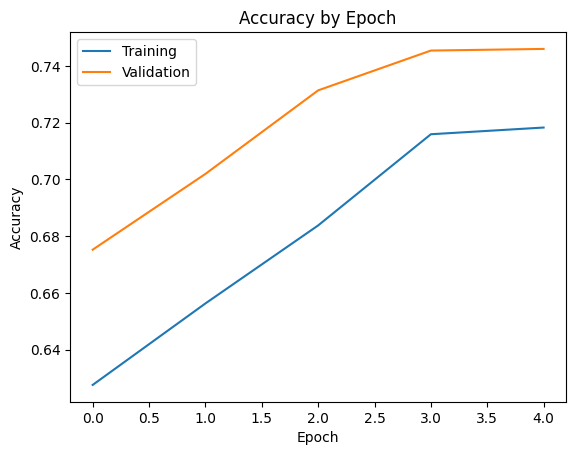

In [43]:
model = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer = optim.Adam(model.parameters())

### for exercise 5

loss_fn = nn.CrossEntropyLoss()

###

train_accuracies = []
validation_accuracies = []
for epoch in range(EPOCHS):
    train_acc = train(model, optimizer, loss_fn,
                          train_dataloader)
    val_acc = evaluate(model, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc:.2f}%")
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

<div dir=rtl>

# ניתוח

6. בתיבת הטקסט להלן, תארו את הגרף שיצא לכם לעיל. הציעו לפחות שני שינויים בהיפר-פרמטרים שלדעתכם עשויים לשפר את התוצאה **וממשו אותם**. לכל ניסוי שכפלו את תיבת הקוד לעיל, שנו את מה שצריך, והריצו מחדש. **השתמשו בשמות משתנים חדשים עבור המודלים והתוצאות**. ניתן לוותר על הדפסות המספרים באפוקי הביניים ולהסתפק בתוצאות הסוף ובגרף.

**אנו רואים מהגרף שככל שמספר האפוקים גדל המודל לומד טוב יותר ויותר והדיוק עולה.
(גם עבור מדגם האימון וגם עבור מדגם הולידציה).
שני שינויים אפשריים יהיו הגדלת מספר השכבות ברשת והגדלת כמות האפוקים, בניסוי הראשון הגדלנו את מספר האפוקים ובניסוי השני את מספר השכבות (מ5 ל15 ומ2 ל3 בהתאמה)**

7. שנו מאפיין של הניסוי ש**אינו** אחד מההיפר-פרמטרים המוגדרים. למשל, השתמשו בקלאס אחר מ-pytorch עבור הרשת הנשנית, המאפטם, או משהו אחר לבחירתכם. או הוסיפו שכבה לינארית למודל.

**שינינו את האופטימייזר להיות גרדיאנט דיסנט סטוכסטי. יש שיפור מינורי בתוצאות**
</div>

## <דווחו כאן>

Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 61.58%
Validation Accuracy: 68.57%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 66.95%
Validation Accuracy: 72.01%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 72.16%
Validation Accuracy: 76.86%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 74.82%
Validation Accuracy: 78.00%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 76.14%
Validation Accuracy: 79.34%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6:
Training Accuracy: 76.98%
Validation Accuracy: 79.45%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7:
Training Accuracy: 77.07%
Validation Accuracy: 79.45%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8:
Training Accuracy: 77.10%
Validation Accuracy: 79.44%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9:
Training Accuracy: 79.05%
Validation Accuracy: 82.78%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10:
Training Accuracy: 82.47%
Validation Accuracy: 83.53%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11:
Training Accuracy: 83.46%
Validation Accuracy: 84.20%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12:
Training Accuracy: 86.13%
Validation Accuracy: 87.37%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13:
Training Accuracy: 88.88%
Validation Accuracy: 88.48%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14:
Training Accuracy: 90.31%
Validation Accuracy: 88.80%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15:
Training Accuracy: 90.86%
Validation Accuracy: 89.04%


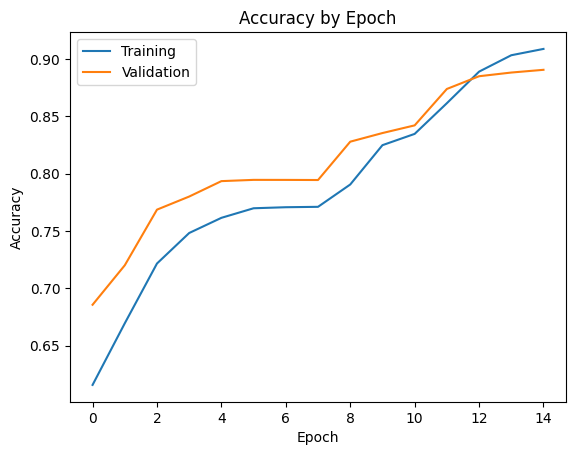

In [48]:
### for exercise 6 ###

BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 15

model_1 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_1 = optim.Adam(model_1.parameters())
loss_fn = nn.CrossEntropyLoss()
train_accuracies_1 = []
validation_accuracies_1 = []
for epoch in range(EPOCHS):
    train_acc_1 = train(model_1, optimizer_1, loss_fn,
                          train_dataloader)
    val_acc_1 = evaluate(model_1, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc_1:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc_1:.2f}%")
    train_accuracies_1.append(train_acc_1)
    validation_accuracies_1.append(val_acc_1)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="Training")
plt.plot(validation_accuracies_1, label="Validation")
plt.legend();

Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 61.71%
Validation Accuracy: 67.64%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 67.05%
Validation Accuracy: 72.11%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 71.31%
Validation Accuracy: 74.43%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 73.10%
Validation Accuracy: 76.82%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 74.83%
Validation Accuracy: 77.19%


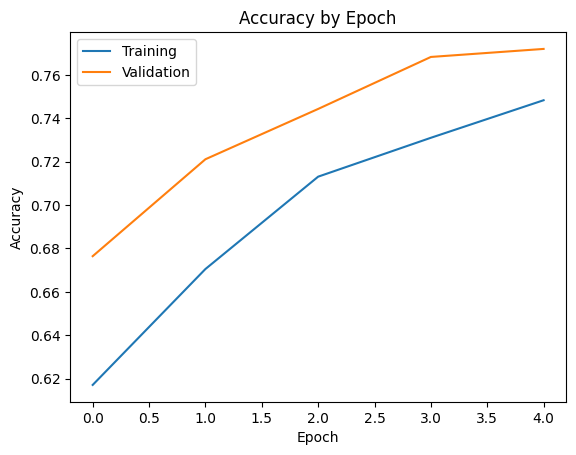

In [44]:
### for exercise 6 ###

BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 3
EPOCHS = 5

model_2 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_2 = optim.Adam(model_2.parameters())
loss_fn = nn.CrossEntropyLoss()
train_accuracies_2 = []
validation_accuracies_2 = []
for epoch in range(EPOCHS):
    train_acc_2 = train(model_2, optimizer_2, loss_fn,
                          train_dataloader)
    val_acc_2 = evaluate(model_2, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc_2:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc_2:.2f}%")
    train_accuracies_2.append(train_acc_2)
    validation_accuracies_2.append(val_acc_2)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_2, label="Training")
plt.plot(validation_accuracies_2, label="Validation")
plt.legend();

Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 63.68%
Validation Accuracy: 67.52%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 65.57%
Validation Accuracy: 70.22%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 68.81%
Validation Accuracy: 74.20%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 71.72%
Validation Accuracy: 74.61%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 71.85%
Validation Accuracy: 74.62%


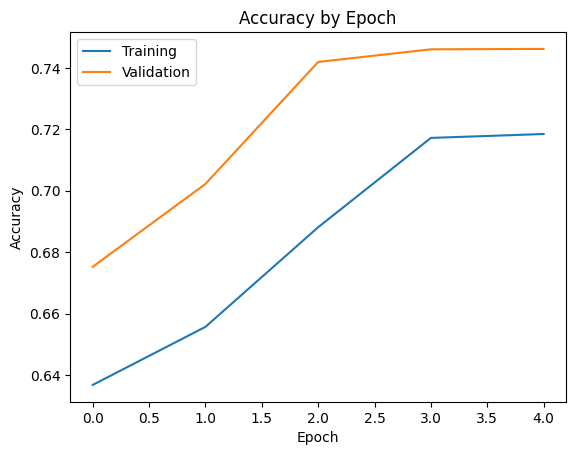

In [46]:
### for exercise 7 ###


BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 5

model_1 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train_accuracies_1 = []
validation_accuracies_1 = []
for epoch in range(EPOCHS):
    train_acc_1 = train(model_1, optimizer_1, loss_fn,
                          train_dataloader)
    val_acc_1 = evaluate(model_1, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc_1:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc_1:.2f}%")
    train_accuracies_1.append(train_acc_1)
    validation_accuracies_1.append(val_acc_1)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="Training")
plt.plot(validation_accuracies_1, label="Validation")
plt.legend();

<div dir=rtl>

## טסט

8. מצאו את המודל הטוב ביותר מאלה שניסיתם עד כה והריצו (פעם אחת בלבד) על הטסט. הקבוצה עם התוצאה הטובה ביותר תקבל בונוס נקודה לציון הסופי בקורס.

</div>

Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 62.80%
Test Accuracy: 65.55%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 67.42%
Test Accuracy: 70.07%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 71.53%
Test Accuracy: 74.62%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 76.44%
Test Accuracy: 78.28%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 77.69%
Test Accuracy: 78.68%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6:
Training Accuracy: 79.03%
Test Accuracy: 81.65%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7:
Training Accuracy: 81.71%
Test Accuracy: 82.83%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8:
Training Accuracy: 84.23%
Test Accuracy: 86.05%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9:
Training Accuracy: 86.89%
Test Accuracy: 86.73%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10:
Training Accuracy: 87.65%
Test Accuracy: 87.07%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11:
Training Accuracy: 87.93%
Test Accuracy: 87.18%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12:
Training Accuracy: 88.06%
Test Accuracy: 87.25%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13:
Training Accuracy: 88.16%
Test Accuracy: 87.41%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14:
Training Accuracy: 88.32%
Test Accuracy: 87.49%


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15:
Training Accuracy: 88.44%
Test Accuracy: 87.59%


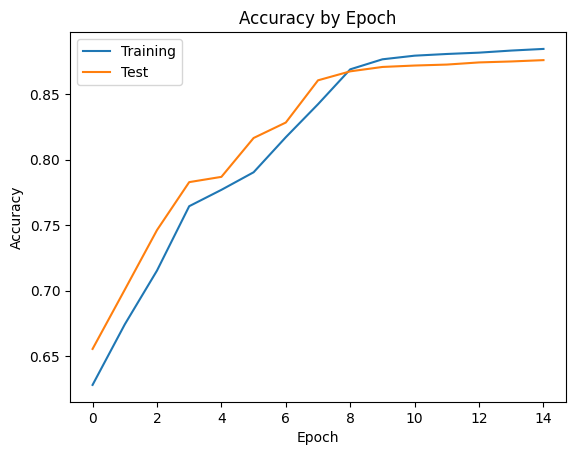

In [50]:
### for exercise 8 ###

BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 15

model_1 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_1 = optim.Adam(model_1.parameters())
loss_fn = nn.CrossEntropyLoss()
train_accuracies_1 = []
test_accuracies_1 = []
for epoch in range(EPOCHS):
    train_acc_1 = train(model_1, optimizer_1, loss_fn,
                          train_dataloader)
    test_acc_1 = evaluate(model_1, test_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc_1:.2f}%")
    print(f"Test Accuracy: {100 * test_acc_1:.2f}%")
    train_accuracies_1.append(train_acc_1)
    test_accuracies_1.append(test_acc_1)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="Training")
plt.plot(test_accuracies_1, label="Test")
plt.legend();

<div dir=rtl>

# העשרה - שיכונים מן המוכן

למי שמעוניין, ניתן להוריד שיכונים (embeddings) של סלבית כנסייתית עתיקה מהכתובת [כאן](https://zenodo.org/records/8414137) ולנסות לשפר את ביצועי המודל. תצטרכו להוריד את המודל, להעלות את הקובץ הרצוי מתוכו לתיקייה המקומית של ה-colab (כפתור התיקייה בטולבר השמאלי), ולטעון אותו באמצעות חבילה כמו `gensim`.  **ללא ציון**.

שימו לב שהורדת השיכונים לוקחת זמן רב. היאזרו בסבלנות או בפרק מנטפליקס.

</div>

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import KeyedVectors

MIN = 1  # change if necessary
WIN = 3  # change if necessary
DIMS = 100  # change if necessary

wv = KeyedVectors.load_word2vec_format(f"/content/TOROT_lemmat_min{MIN}_win{WIN}_dims{DIMS}_ep5_vectors.txt")

In [ ]:
len(wv.key_to_index.items())

In [ ]:
list(wv.key_to_index.items())[3000:3005]

In [ ]:
### go crazy... ###